# Import needed modules and useful functions

In [1]:
#-- useful python script to compute the TICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :70,
}
#--------------------------------------#

# Prepare input files for plumed

In [3]:
folder = "unbias_A/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2 
psi: TORSION ATOMS=@psi-2
omega: TORSION ATOMS=5,6,7,9
theta: TORSION ATOMS=9,15,17,18

#energy
ene: ENERGY

INCLUDE FILE=plumed_descriptors.data

# every 1 ps
PRINT FMT=%g STRIDE=500 FILE=COLVAR ARG=*

ENDPLUMED
""",file=file)

#-- run gromacs --#
execute("cp script/input.* script/plumed_descriptors.data script/run_gromacs.sh "+folder,folder=".")
execute("./run_gromacs.sh",folder=folder)

data = load_dataframe(folder+"COLVAR")

Completed: cp script/input.* script/plumed_descriptors.data script/run_gromacs.sh unbias_A/
Completed: ./run_gromacs.sh


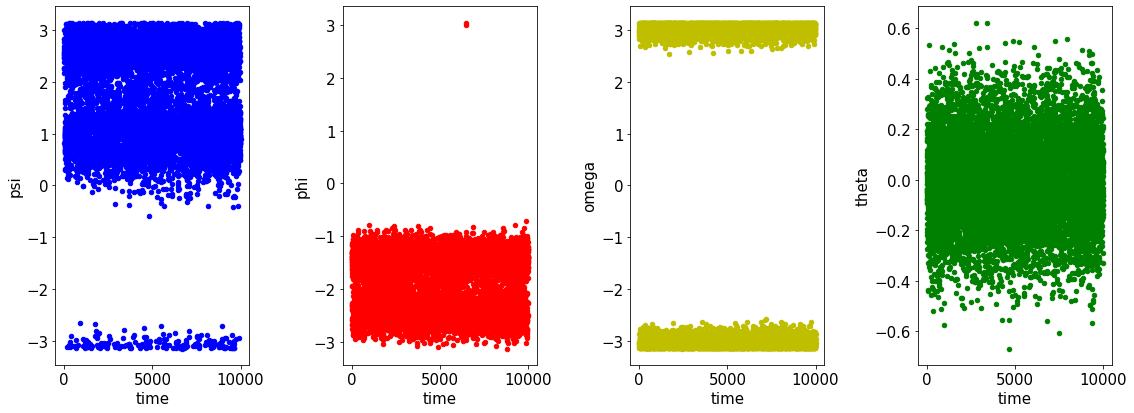

In [4]:
fig,axs = plt.subplots(1,4,figsize=(16,6))
data.plot.scatter(x="time",y="psi",ax=axs[0], color="b")
data.plot.scatter(x="time",y="phi",ax=axs[1], color="r")
data.plot.scatter(x="time",y="omega",ax=axs[2], color="y")
data.plot.scatter(x="time",y="theta",ax=axs[3], color="g")
plt.tight_layout()

Text(0, 0.5, '$\\psi$')

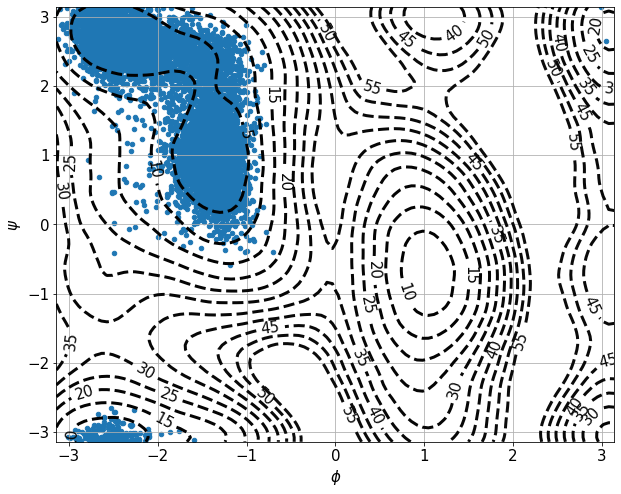

In [5]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
load_dataframe(folder+"COLVAR").plot.scatter(y="psi",x="phi",ax=ax)

fes = np.loadtxt("../../../../angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("../../../../angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("../../../../angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax.contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax.grid()
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")

<AxesSubplot:xlabel='psi', ylabel='omega'>

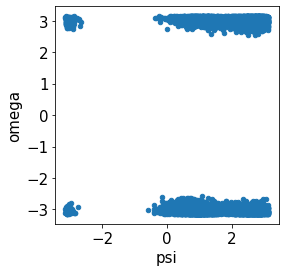

In [6]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
load_dataframe(folder+"COLVAR").plot.scatter(y="omega",x="psi",ax=ax)

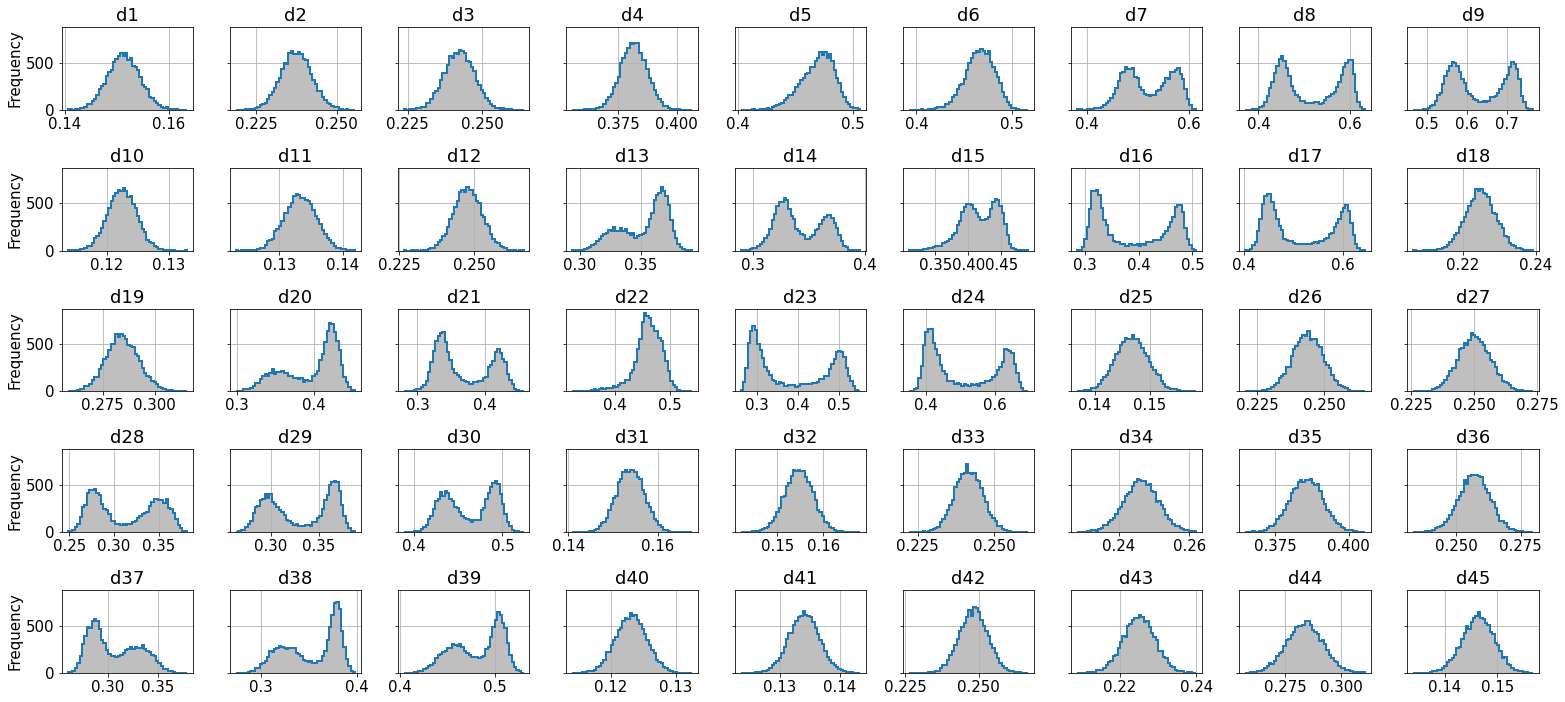

In [7]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values

fig,axs = plt.subplots(5,9,figsize=(22,10),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2)#,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey")#,density=True)
    ax.set_title(desc)

plt.tight_layout()

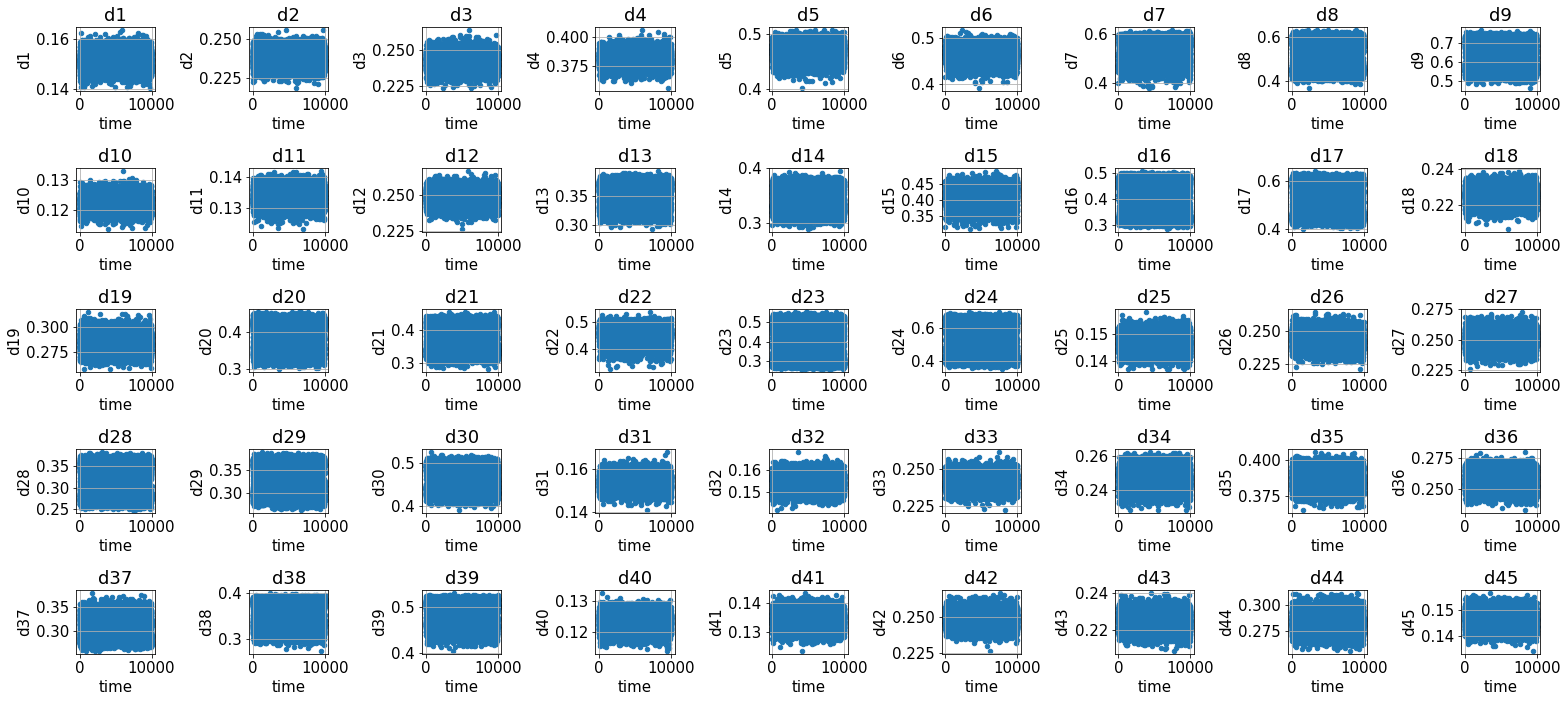

In [8]:
fig,axs = plt.subplots(5,9,figsize=(22,10))#,sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data.plot.scatter(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True)#,density=True)
    ax.set_title(desc)

plt.tight_layout()

In [9]:
#-- TRAINING PARAMETERS --#
train_parameters = {
              'descriptors': '^d[^a-z]',
              'lag_time':6,
              'standardize_outputs':True,
              'standardize_inputs': True,
              #if reweight the timescale
              "reweighting": False,
              "step": 1 #
              }
#--------------------------------------#

In [10]:
'''
data = load_dataframe(folder+"COLVAR")
data = data[::train_parameters["step"]]
X, names, t = data.filter(regex='^d[^a-z]').values, data.filter(regex='^d[^a-z]').columns.values, data['time'].values

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = TICA_CV(n_features=X.shape[1])
model.to(device)

lags = np.linspace(1,10,10)
timescale = np.empty(len(lags))

for i,lag in enumerate(lags):
    # TRAIN
    model.fit(X, t, lag=lag)
    #-- move the model back to cpu for convenience --# 
    timescale[i] = model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1]
model.to('cpu')
'''

'\ndata = load_dataframe(folder+"COLVAR")\ndata = data[::train_parameters["step"]]\nX, names, t = data.filter(regex=\'^d[^a-z]\').values, data.filter(regex=\'^d[^a-z]\').columns.values, data[\'time\'].values\n\n# DEVICE\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\n# MODEL\nmodel = TICA_CV(n_features=X.shape[1])\nmodel.to(device)\n\nlags = np.linspace(1,10,10)\ntimescale = np.empty(len(lags))\n\nfor i,lag in enumerate(lags):\n    # TRAIN\n    model.fit(X, t, lag=lag)\n    #-- move the model back to cpu for convenience --# \n    timescale[i] = model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1]\nmodel.to(\'cpu\')\n'

In [11]:
#plt.plot(lags,timescale)
#print(timescale)
#print(lags)

## DeepTICA Analysis and Export

In [12]:
torch.manual_seed(21)

#data
data = load_dataframe(folder+"COLVAR")
data = data[::train_parameters["step"]]
X, names, t = data.filter(regex='^d[^a-z]').values, data.filter(regex='^d[^a-z]').columns.values, data['time'].values

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = TICA_CV(n_features=X.shape[1])
model.to(device)

# TRAIN
model.fit(X, t, lag=train_parameters["lag_time"])

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- print some useful results --#
#print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
#print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

model.set_params({"feature_names": names})
print( model.plumed_input().splitlines()[:2] )

eigenvalues:  [ 0.41627952  0.13697709  0.12565237  0.10751205  0.08314829  0.08126839
  0.07420921  0.07216216  0.06703662  0.06121368  0.0521933   0.04771792
  0.04486143  0.04274368  0.04015804  0.03294126  0.02894891  0.02749235
  0.02067152  0.01642775  0.0141965   0.00516071  0.00436814  0.00045631
 -0.00313483 -0.00654497 -0.00895039 -0.01144408 -0.01663091 -0.01821515
 -0.02363371 -0.02470683 -0.0307469  -0.03409334 -0.03923095 -0.04459067
 -0.04640776 -0.04898056 -0.0507428  -0.06059988 -0.06436381 -0.06906351
 -0.07565355 -0.07977845 -0.08998439]
['tica_cv1: CUSTOM ARG=d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45 VAR=x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44 FUNC=0.056300*(x0-0.151315)-0.056060*(x1-0.237481)-0.040333*(x2-0.242

#### Adding to data the cvs values

In [13]:
descriptors_names = data.filter(regex='^d[^a-z]').columns.values
data_complete = load_dataframe("../../../../angles/COLVAR")
X_complete = data_complete[descriptors_names].to_numpy()

In [14]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data["cv3"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[2]
data["cv4"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[3]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]
data_complete["cv3"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[2]
data_complete["cv4"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[3]

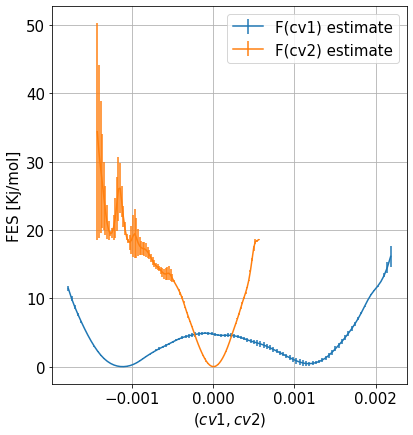

In [15]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^cv").to_numpy()
logweight=np.zeros(s.shape[0])

fig, ax = plt.subplots(figsize=(6,6))
cvs_fes=[]
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
    cvs_fes.append(fes)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

<AxesSubplot:ylabel='Frequency'>

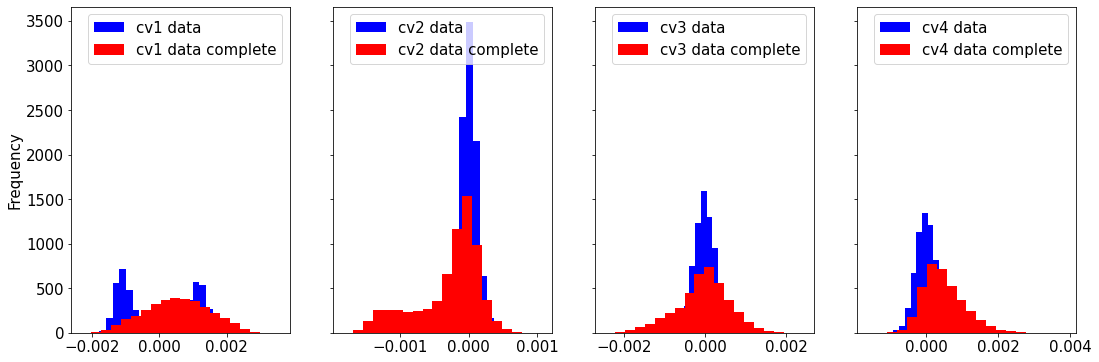

In [16]:
fig,axs = plt.subplots(1,4,figsize=(18,6),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b",label="cv1 data")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="b",label="cv2 data")
data.plot.hist(y="cv3",bins=20,ax=axs[2],density=True,color="b",label="cv3 data")
data.plot.hist(y="cv4",bins=20,ax=axs[3],density=True,color="b",label="cv4 data")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="r",label="cv1 data complete")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r",label="cv2 data complete")
data_complete.plot.hist(y="cv3",bins=20,ax=axs[2],density=True,color="r",label="cv3 data complete")
data_complete.plot.hist(y="cv4",bins=20,ax=axs[3],density=True,color="r",label="cv4 data complete")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

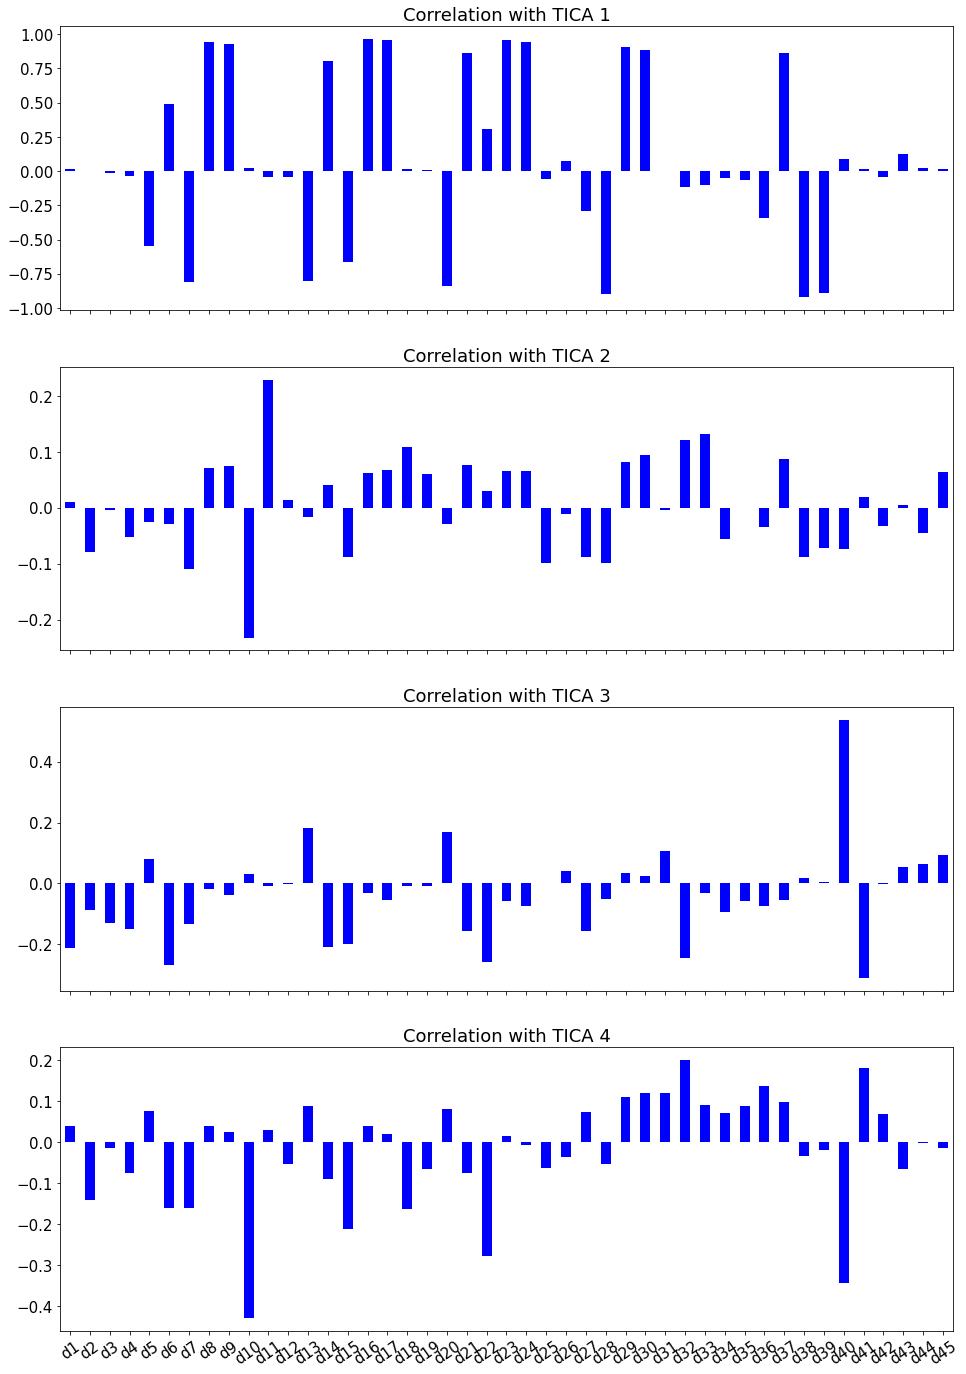

In [17]:
fig,axs = plt.subplots(4,1,figsize=(16,24),sharex=True)
for k,cv in enumerate(["cv1","cv2","cv3","cv4"]):
    cols = [cv]
    cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
    corr = data[cols].corr(method='pearson')
    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35, color="b",label=r"$C(tica|desc)$")
    axs[k].set_title('Correlation with TICA '+str(k+1))
plt.show()

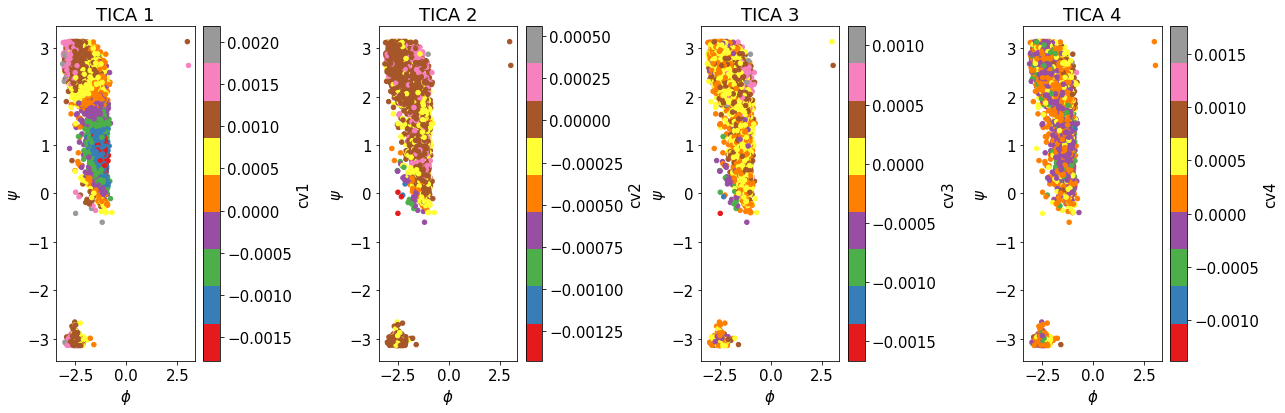

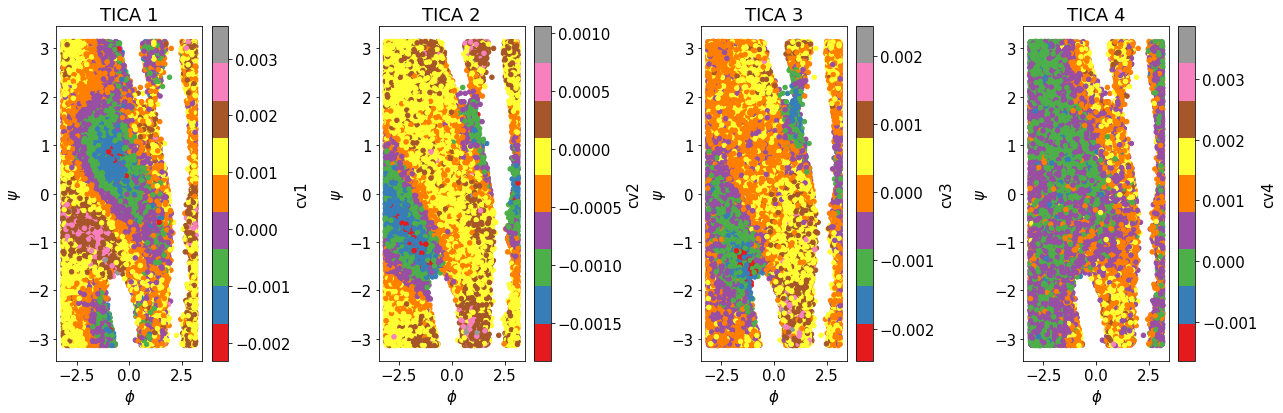

In [18]:
fig,axs = plt.subplots(1,4,figsize=(18,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,4,figsize=(18,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('TICA '+str(k+1))
plt.tight_layout()

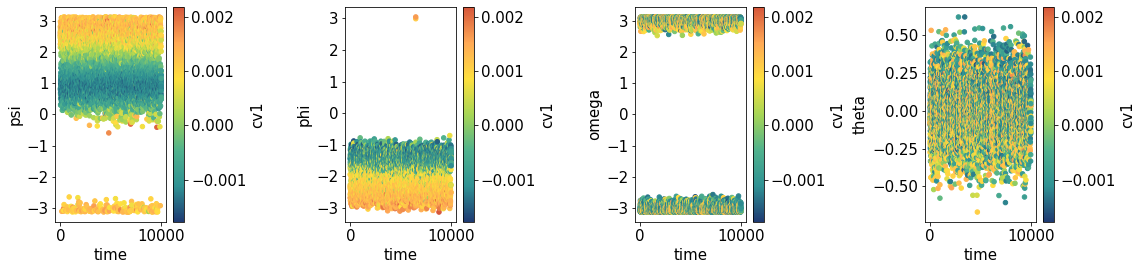

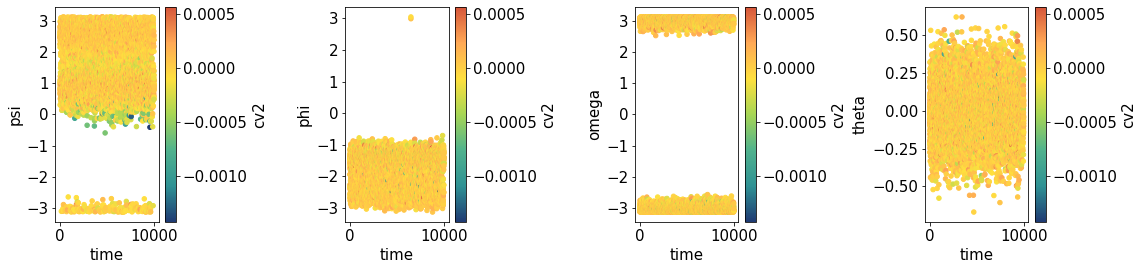

In [19]:
names = ["psi","phi","omega","theta"]
fig,axs = plt.subplots(1,4,figsize=(16,4))
for i,ax in enumerate(axs):
    data.plot.scatter(y=names[i],x="time",c="cv1",cmap="fessa",ax=ax)
plt.tight_layout()
fig,axs = plt.subplots(1,4,figsize=(16,4))
for i,ax in enumerate(axs):
    data.plot.scatter(y=names[i],x="time",c="cv2",cmap="fessa",ax=ax)
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [20]:
Boltzmann_product(model,model,X,j=0,k=1)

-1.2876999611993486e-09

# Prepare the next simulation input files
### Plumed

## First possibility : excluded region

In [21]:
## excluded region
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values
excluded_region = "xx: CUSTOM ...\n\tPERIODIC=NO\n\tARG="
for desc in descriptors_names:
    excluded_region += desc
    if desc is not descriptors_names[-1]:
        excluded_region += ","
excluded_region += "\n\tVAR="

for i in range(len(descriptors_names)):
    var = "x"+str(i)
    excluded_region += var
    if i is not len(descriptors_names)-1:
        excluded_region += ","

excluded_region += "\n\tFUNC="

for i,desc in enumerate(descriptors_names):
    func = "step((x"+str(i)+"-"+str(np.round(min(data[desc]),3))+")*(x"+str(i)+"-"+str(np.round(max(data[desc]),3))+"))"
    excluded_region += func
    if desc is not descriptors_names[-1]:
        excluded_region += "+" 

excluded_region += "\n..."

print(excluded_region)

xx: CUSTOM ...
	PERIODIC=NO
	ARG=d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45
	VAR=x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44
	FUNC=step((x0-0.14)*(x0-0.164))+step((x1-0.219)*(x1-0.256))+step((x2-0.224)*(x2-0.264))+step((x3-0.356)*(x3-0.406))+step((x4-0.402)*(x4-0.506))+step((x5-0.392)*(x5-0.517))+step((x6-0.38)*(x6-0.615))+step((x7-0.371)*(x7-0.632))+step((x8-0.466)*(x8-0.764))+step((x9-0.114)*(x9-0.133))+step((x10-0.123)*(x10-0.142))+step((x11-0.227)*(x11-0.266))+step((x12-0.294)*(x12-0.392))+step((x13-0.289)*(x13-0.395))+step((x14-0.31)*(x14-0.491))+step((x15-0.285)*(x15-0.507))+step((x16-0.403)*(x16-0.644))+step((x17-0.206)*(x17-0.239))+step((x18-0.258)*(x18-0.316))+step((x19-0.298)*(x19-0.454))+step((x20-0.28)*(x20-0.457))+step((x21

In [22]:
folder = "unbias_A/bias1/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2 
psi: TORSION ATOMS=@psi-2
omega: TORSION ATOMS=5,6,7,9
theta: TORSION ATOMS=9,15,17,18

#energy
ene: ENERGY

# include descriptors
INCLUDE FILE=plumed_descriptors.data
# define cv
"""+
model.plumed_input().splitlines()[0]+"""\n"""+model.plumed_input().splitlines()[1]
+"""
#excluded region
"""+
excluded_region
+"""
# bias 
opes: OPES_METAD ARG=tica_cv1,tica_cv2 TEMP=300 PACE=500 EXCLUDED_REGION=xx FILE=KERNELS BARRIER=25 STATE_WFILE=RestartKernels STATE_WSTRIDE=500*10
 
# every 1 ps
PRINT FMT=%g STRIDE=500 FILE=COLVAR ARG=*

ENDPLUMED
""",file=file)

#-- run gromacs --#
execute("cp script/input.* script/plumed_descriptors.data script/run_gromacs.sh "+folder,folder=".")

Completed: cp script/input.* script/plumed_descriptors.data script/run_gromacs.sh unbias_A/bias1/


In [23]:
#!cat unbias_A/bias1/plumed.dat

## Second possibility: costant cv outside the training region 
Value set to 0 using the step functions, or with a more slightly functions like exponentials